# Clustering Exercise

Go to
https://figshare.com/articles/News-Processed-Dataset/5296357 and download `WSJ_20170607_to_20170726_10AmTo4Pm.json` (the small file of 9 MB)

In [1]:
#imports: 
import numpy as np
import matplotlib.pyplot as plt

#define some functions to visualize results:
#NOTE: you do not need to change these functions!
def plot_dimensionality_reduction(X_reduced, model):

    #determine the method name based on the model class
    if isinstance(model, TruncatedSVD):
        method_name = 'SVD'
    elif isinstance(model, PCA):
        method_name = 'PCA'
    else:
        method_name = type(model).__name__  #dallback to the class name if unknown
    
    #get the explained variance ratio (need for plots)
    explained_variance_ratio = model.explained_variance_ratio_

    #create a figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. 3D scatter plot of first three components
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c='b', alpha=0.5)
    ax1.set_xlabel(f'{method_name}1')
    ax1.set_ylabel(f'{method_name}2')
    ax1.set_zlabel(f'{method_name}3')
    ax1.set_title(f'First Three {method_name} Components')
    
    # 2. Explained variance ratio
    ax2 = fig.add_subplot(222)
    ax2.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    ax2.set_xlabel(f'{method_name} Component')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title(f'Explained Variance Ratio by {method_name} Component')
    
    # 3. Cumulative explained variance ratio
    ax3 = fig.add_subplot(223)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    ax3.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
    ax3.set_xlabel('Number of Components')
    ax3.set_ylabel('Cumulative Explained Variance Ratio')
    ax3.set_title('Cumulative Explained Variance Ratio')
    
    # 4. Scatter plot of first two components
    ax4 = fig.add_subplot(224)
    ax4.scatter(X_reduced[:, 0], X_reduced[:, 1], c='r', alpha=0.5)
    ax4.set_xlabel(f'{method_name}1')
    ax4.set_ylabel(f'{method_name}2')
    ax4.set_title(f'First Two {method_name} Components')
    
    plt.tight_layout()
    plt.show()
def print_top_terms(model, vectorizer, top_n_dim = 10, n_top_terms=10):
    """
    Print top terms associated with each component.
    The method name is automatically determined from the model object.
    
    Args:
    model: Fitted SVD or PCA object
    vectorizer: Fitted TF-IDF vectorizer
    n_top_terms (int): Number of top terms to print for each component
    """
    # Determine the method name based on the model class
    if isinstance(model, TruncatedSVD):
        method_name = 'SVD'
    elif isinstance(model, PCA):
        method_name = 'PCA'
    else:
        method_name = type(model).__name__  # Fallback to the class name if unknown

    feature_names = vectorizer.get_feature_names_out()
    for i, comp in enumerate(model.components_[:top_n_dim]):
        top_terms = [feature_names[idx] for idx in comp.argsort()[:-n_top_terms - 1:-1]]
        print(f"{method_name} Component {i + 1}: {', '.join(top_terms)}")
def visualize_clusters(features, cluster_labels, k):
    
    # Reduce the feature space to 2D for visualization
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features.toarray())

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                          c=cluster_labels, cmap='viridis')

    # Add labels and title
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('K-means Clustering Results')

    # Add a color bar
    plt.colorbar(scatter, label='Cluster')

    # Add cluster centers
    centers = kmeans.cluster_centers_
    reduced_centers = pca.transform(centers)
    plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], 
                marker='x', s=200, linewidths=3, color='r', label='Cluster Centers')

    plt.legend()
    plt.show()

#set your data directory:
datadir = '/Users/rupertkiddle/Desktop/teach/2024/Introduction to Machine Learning (GESIS)/3_datasets/'

## 1. Load in the WSJ dataset (or your own):

In [2]:
import json #for reading json files

#load your data:
with open(datadir+'WSJ//WSJ_20170607_to_20170726_10AmTo4Pm.json', encoding="utf-8") as f:
  texts = [json.loads(line)['content'] for line in f]

#inspect:
print(f"We're dealing with a {type(texts)} of length {len(texts)}...")
print(f"...the first text is: {texts[0]}") #print first text

We're dealing with a <class 'list'> of length 2062...
...the first text is: Uber Technologies Inc., trying to reshape its image after a series of scandals this year, said Tuesday it will let drivers collect tips through its app for the first time as part of new driver-friendly features.Allowing tips via the app removes a longstanding source of contention between the ride-hailing company and its drivers. Uber’s U.S. rival, Lyft Inc., has long offered a tipping option through its app, giving it an advantage in recruiting drivers. Uber has allowed drivers to accept cash tips.Uber’s new tipping option is now available in Seattle, Houston and Minneapolis and will expand to other U.S. cities in the coming weeks. It is part of several new features Uber announced as it aims to improve earnings and keep drivers from defecting.In recent months, the San Francisco-based company has been buffeted by charges of rampant sexual harassment and sexism, an exodus of high-level executives and an admission

In [3]:
import re #for regular expressions
import nltk #for nlp (here: tokenization)
from nltk.corpus import stopwords #for stopwords
from nltk.stem import WordNetLemmatizer #for lemmatization

def preprocess_text(texts, custom_stopwords=None):
    #NOTE: better lemmatizer that uses the WordNet lexical database.
    #NOTE: you can even pass it POS tags to improve the lemmatization (not done here).
    lemmatizer = WordNetLemmatizer() 
    #get the default stopwords from NLTK (en).
    stop_words = set(stopwords.words('english'))
    
    #add custom stopwords if provided
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    #instantiate an empty list for processed texts
    processed_texts = []

    #interate over the texts
    for text in texts:
        try:
            #lowercase
            text = text.lower()

            #tokenize with NLTK tokenizer
            tokens = nltk.word_tokenize(text)
            
            #remove non-alphabetic characters from tokens
            tokens = [re.sub(r'[^a-z\s]', '', token) for token in tokens]
            
            #combined stopwords removal and lemmatization
            tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
            
            #join tokens back to string=
            processed_text = ' '.join(tokens)

            #remove any double spaces that remain:
            processed_text = re.sub(r'\s+', ' ', processed_text).strip()
            
            #append processed text to output list:
            processed_texts.append(processed_text)
        
        except Exception as e: #raise error if smth goes wrong: 
            print(f"Error processing text: {text}. Error: {e}")
            processed_texts.append("")
    
    return processed_texts

In [7]:
#execute preprocessing:
texts = preprocess_text(texts)

## 2. Try out some dimensional reduction techniques, such as `PCA` or `SVD`:

#### PCA: 

Original number of features: 65659
Reduced number of features: 10
Reduced data shape: (2062, 10)


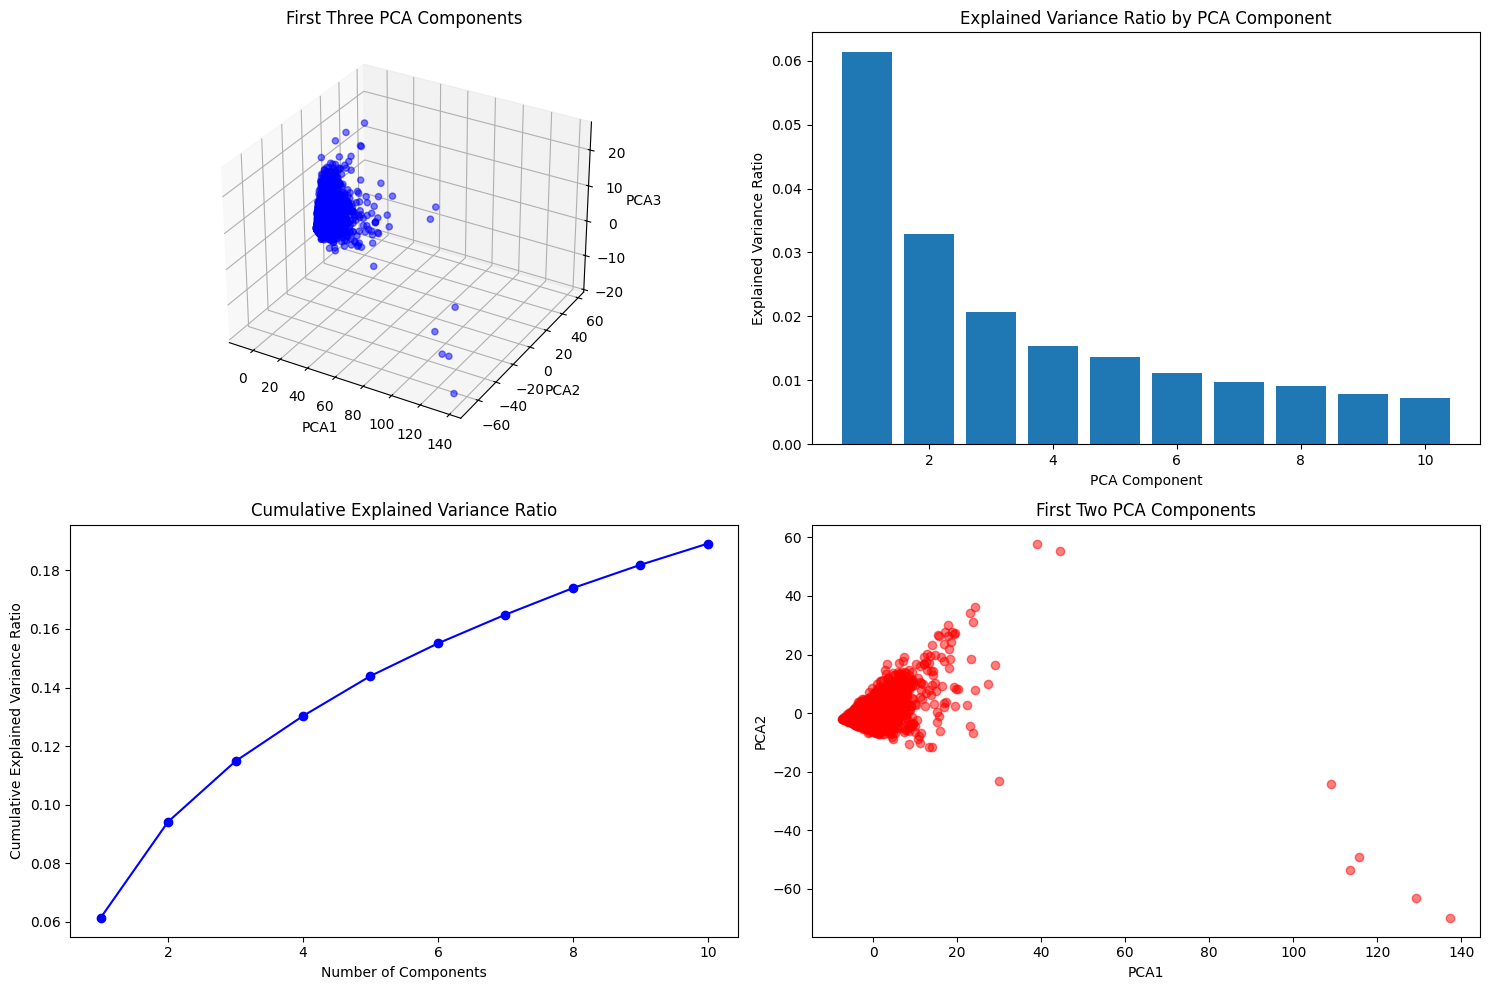

PCA Component 1: mr, think, trump, said, would, going, president, say, people, get
PCA Component 2: mr, said, trump, official, white, comey, president, investigation, house, moore
PCA Component 3: said, company, year, bank, market, billion, price, investor, rate, last
PCA Component 4: say, company, mr, new, one, like, year, time, make, music
PCA Component 5: said, state, company, bill, hospital, million, health, people, city, court
PCA Component 6: company, trump, billion, china, business, tax, deal, bill, inc, share
PCA Component 7: bill, would, tax, senate, republican, health, house, mr, gop, plan
PCA Component 8: eu, uk, government, country, say, european, state, china, would, brexit
PCA Component 9: china, north, korea, chinese, people, tax, health, hospital, say, state
PCA Component 10: bank, say, eu, hospital, company, patient, google, court, uk, would


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer


# Initialize a vectorizer:
my_vect = CountVectorizer()

# Initialize PCA object:
my_pca = PCA(n_components=10)

# Create a pipeline that vectorizes -> transforms to dense and -> runs PCA:
# NOTE: pipelines are a good way to combine multiple transformation steps into one object.
mypipe = make_pipeline(
    my_vect,
    FunctionTransformer(lambda x: np.asarray(x.todense()), accept_sparse=True),
    my_pca
)

#run the pipeline on the processed texts:
X_pca = mypipe.fit_transform(texts)

#print the number of dimensions in the DTM:
print(f"Original number of features: {len(my_vect.get_feature_names_out())}")
print(f"Reduced number of features: {X_pca.shape[1]}")
print(f"Reduced data shape: {X_pca.shape}")

#print plots of PCA results:
plot_dimensionality_reduction(X_pca, my_pca)

#report top terms for each PC:
print_top_terms(my_pca, my_vect)

#### SVD:

Original number of features: 65659
Reduced number of features: 500
Reduced data shape: (2062, 500)


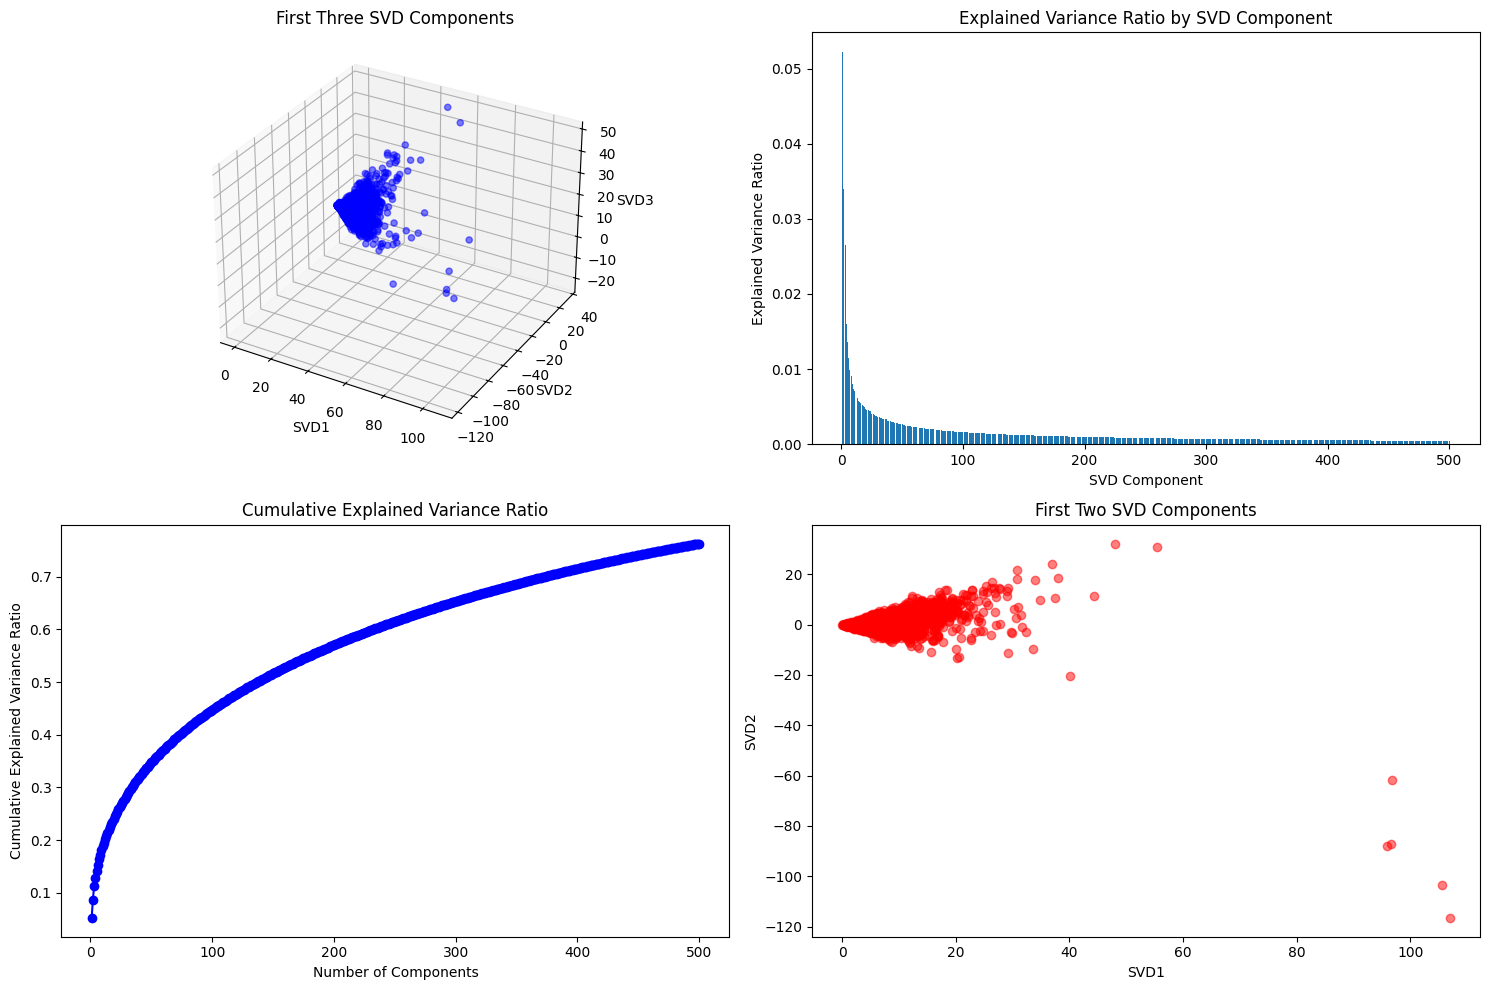

SVD Component 1: said, mr, year, would, trump, new, say, one, company, think
SVD Component 2: mr, said, company, year, according, official, wsjcom, last, bank, billion
SVD Component 3: mr, trump, president, house, comey, white, think, republican, russian, russia
SVD Component 4: said, trump, bank, would, bill, state, tax, official, president, senate
SVD Component 5: said, company, state, bill, million, hospital, people, health, city, new
SVD Component 6: company, billion, china, trump, business, mr, inc, share, investment, deal
SVD Component 7: bill, would, tax, senate, republican, house, health, gop, state, plan
SVD Component 8: eu, government, uk, country, china, european, state, trade, brexit, say
SVD Component 9: china, north, korea, say, chinese, people, tax, hospital, health, patient
SVD Component 10: bank, say, eu, court, hospital, uk, patient, company, said, google


In [15]:
#initialize a vectorizer:
my_vect = CountVectorizer()

#initialize TruncatedSVD object:
my_svd = TruncatedSVD(n_components=500)

# Create a pipeline that vectorizes -> runs SVD -> normalizes the results:
mypipe = make_pipeline(
    my_vect,
    my_svd,
)

#run the pipeline on the processed texts:
X_svd = mypipe.fit_transform(texts)

#print the number of dimensions in the DTM and reduced data:
print(f"Original number of features: {len(my_vect.get_feature_names_out())}")
print(f"Reduced number of features: {X_svd.shape[1]}")
print(f"Reduced data shape: {X_svd.shape}")

#get plots of SVD results:
plot_dimensionality_reduction(X_svd, my_svd)

# Report top terms for each SVD component:
print_top_terms(my_svd, my_vect)

## 4. Next, run the `kmeans`algorithm and try to determine the right number of `k`.   

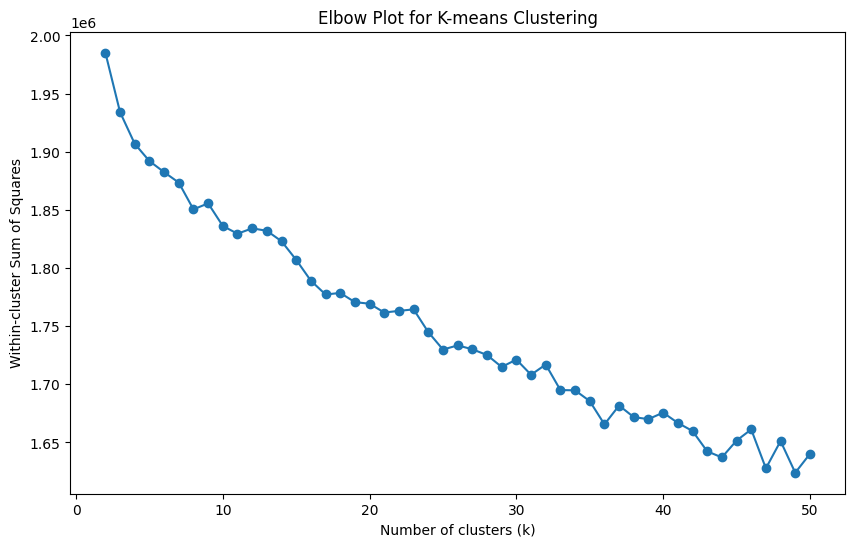

In [11]:
from sklearn.cluster import KMeans

#initialize a vectorizer: 
vectorizer = CountVectorizer()

#transform texts into a document-term matrix:
features = vectorizer.fit_transform(texts)

#perform K-means clustering for different values of k
wss = []  #within-cluster sum of squares
max_k = 50  #maximum number of clusters to try

for k in range(2, max_k + 1):
    #print(f"Trying k={k}")
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=42)
    km.fit(features)
    wss.append(km.inertia_)  # inertia_ gives the sum of squares within clusters

#create the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), wss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares')
plt.title('Elbow Plot for K-means Clustering')
plt.show()

In [16]:
# Import necessary libraries (assumed to be done earlier)
from sklearn.cluster import KMeans

# Set the number of clusters (k) based on the elbow plot analysis
k = 40  # Change this value according to your elbow plot results

# Perform K-means clustering with the chosen k
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Function to get the top words for each cluster
def get_top_words(center, feature_names, top_n=10):
    sorted_indices = center.argsort()[::-1]
    return [feature_names[i] for i in sorted_indices[:top_n]]

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Count documents in each cluster
cluster_sizes = [sum(cluster_labels == i) for i in range(k)]

# Print the number of documents in each cluster
print("Number of documents in each cluster:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i+1}: {size} documents")

#print a few example texts from each cluster
print("\nExample texts from each cluster:")
for i in range(k):
    cluster_texts = [text for text, label in zip(texts, cluster_labels) if label == i]
    print(f"\nCluster {i+1}:")
    for text in cluster_texts[:3]:  # Print first 3 texts in the cluster
        print(f"- {text[:50]}...")  # Print first 50 characters of each text

Number of documents in each cluster:
Cluster 1: 1 documents
Cluster 2: 63 documents
Cluster 3: 2 documents
Cluster 4: 784 documents
Cluster 5: 1 documents
Cluster 6: 103 documents
Cluster 7: 2 documents
Cluster 8: 1 documents
Cluster 9: 1 documents
Cluster 10: 1 documents
Cluster 11: 21 documents
Cluster 12: 48 documents
Cluster 13: 1 documents
Cluster 14: 1 documents
Cluster 15: 2 documents
Cluster 16: 41 documents
Cluster 17: 1 documents
Cluster 18: 1 documents
Cluster 19: 22 documents
Cluster 20: 1 documents
Cluster 21: 31 documents
Cluster 22: 1 documents
Cluster 23: 7 documents
Cluster 24: 10 documents
Cluster 25: 111 documents
Cluster 26: 1 documents
Cluster 27: 1 documents
Cluster 28: 408 documents
Cluster 29: 3 documents
Cluster 30: 1 documents
Cluster 31: 10 documents
Cluster 32: 276 documents
Cluster 33: 6 documents
Cluster 34: 38 documents
Cluster 35: 2 documents
Cluster 36: 24 documents
Cluster 37: 1 documents
Cluster 38: 2 documents
Cluster 39: 1 documents
Cluster 40: 30 d

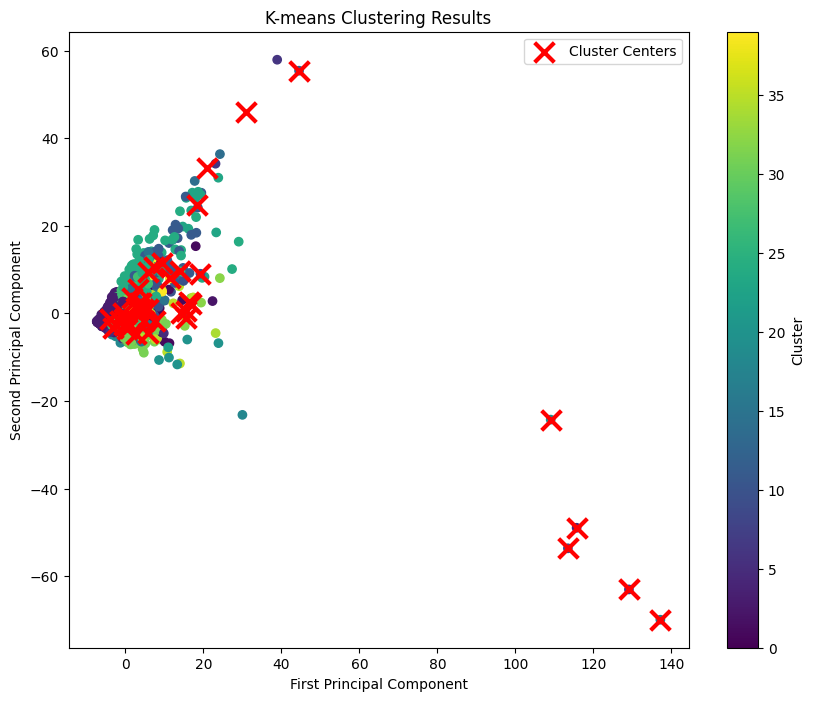

In [13]:
# Call the function to visualize clusters
visualize_clusters(features, cluster_labels, k)